# Code for paper Fairness risk measures
> https://arxiv.org/abs/1901.08665

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.optimize import minimize
from sklearn.metrics import balanced_accuracy_score

from utils.data.load_adult import load_adult

In [2]:
def hinge_loss(actual: np.ndarray, predicted: np.ndarray) -> float:
    loss = np.array(1 - np.multiply(actual, predicted)).clip(0)
    return loss


def square_hinge_loss(actual: np.ndarray, predicted: np.ndarray) -> float:
    return hinge_loss(actual, predicted) ** 2


def cvar(
    losses: np.ndarray, subgroups: list, p: float, alpha: float, clip: bool = True
) -> float:
    """Conditional Value at Risk / superquantile
    Loss aggregator, analogous to E[X | X > alpha-quantile]

    Set p=0, alpha=0 for the expected value

    :param subgroup_losses: losses per subgroup to aggregate over
    :param p: discard all subgroup risks lower then p
    :param alpha: degree of fairness
    :param clip: clip negative values to zero, this makes the function non-continuous
    :return: aggregated losses
    """
    subgroup_losses = [losses[mask] for mask in subgroups]

    # compute the subgroup mean losses
    subgroup_mean_losses = np.zeros(len(subgroup_losses))
    for i, subgroup_loss in enumerate(subgroup_losses):
        # calculate the expected loss over the subgroup
        mean = np.mean(subgroup_loss - p) ** 2
        subgroup_mean_losses[i] = mean

    if clip:
        # NOTE this operation is not continuous!
        subgroup_mean_losses = subgroup_mean_losses.clip(min=0)

    return p + 1 / (1 - alpha) * np.mean(subgroup_mean_losses)


def predict(w: np.ndarray, x: np.ndarray, threshold: bool = False) -> np.ndarray:
    y_hat = x @ np.expand_dims(w, 1)

    if threshold:
        y_hat[y_hat < 0] = -1.0
        y_hat[y_hat >= 0] = 1.0

    return y_hat


def regularised_linear_scorer(w, x, y, loss, lmbd=0.1):
    """loss + L2 regularization

    :param w: weights
    :param x: data points
    :param y: true values
    :param lmdb: weight regularization
    :return: loss(y, x*w) + lmbda * ||w||_2^2
    """
    y_pred = predict(w, x)  # linear scorer
    regularisation = norm(w, 2)  # L2 regularization
    return loss(y, y_pred) + lmbd * regularisation


def optimize(
    x: np.ndarray, y: np.ndarray, alpha: float, lmbd: float, verbose: bool = False
):
    # get the indices of the groups induced by the sensitive feature
    sensitive_feature = 9
    sensitive_feature_values = np.unique(x[:, sensitive_feature])
    mask = []
    for _, value in enumerate(sensitive_feature_values):
        mask.append(x[:, sensitive_feature] == value)

    x0 = np.zeros(x.shape[1] + 1)

    def f(params):
        return cvar(
            regularised_linear_scorer(params[:-1], x, y, square_hinge_loss, lmbd=lmbd),
            subgroups=mask,
            p=params[-1],
            alpha=alpha,
        )

    if verbose:
        print(f"--> Minimizing the objective for alpha={alpha} and lambda={lmbd} ...")
    return minimize(f, x0, options={"disp": verbose})


def main(
    x_train: np.ndarray,
    y_train: np.ndarray,
    x_test: np.ndarray,
    y_test: np.ndarray,
    lmbd: float,
    alpha: float,
):
    result = optimize(x_train, y_train, alpha=alpha, lmbd=lmbd, verbose=True)

    w = result.x[:-1]
    p = result.x[-1]

    print(f"p_val: {p}")

    # get the indices of the groups induced by the sensitive feature
    sensitive_feature = 9
    sensitive_feature_values = np.unique(x_train[:, sensitive_feature])
    mask_train = []
    mask_test = []
    for value in sensitive_feature_values:
        mask_train.append(
            np.logical_and(
                x_train[:, sensitive_feature] == value, y_train.flatten() == 1
            )
        )
        mask_test.append(
            np.logical_and(x_test[:, sensitive_feature] == value, y_test.flatten() == 1)
        )

    y_predict = predict(w, x_test, threshold=True)
    acc = balanced_accuracy_score(y_test, y_predict)
    eo = np.abs(
        np.mean(y_predict[mask_test[0]].clip(0))
        - np.mean(y_predict[mask_test[1]].clip(0))
    )

    return acc, eo

--> Minimizing the objective for alpha=0.1 and lambda=0.1 ...
Optimization terminated successfully.
         Current function value: 0.546305
         Iterations: 17
         Function evaluations: 300
         Gradient evaluations: 20
p: 0.29941557831075516
Training data balanced accuracy: 0.76
Training data equality of opportunity: 0.8137783739006565
Test data balanced accuracy: 0.75
Test data equality of opportunity: 0.37170833698838934
<-- Done!
--> Minimizing the objective for alpha=0.2 and lambda=0.1 ...
Optimization terminated successfully.
         Current function value: 0.573880
         Iterations: 17
         Function evaluations: 300
         Gradient evaluations: 20
p: 0.3520733678983717
Training data balanced accuracy: 0.76
Training data equality of opportunity: 0.7775377802551715
Test data balanced accuracy: 0.75
Test data equality of opportunity: 0.3548360616817872
<-- Done!
--> Minimizing the objective for alpha=0.3 and lambda=0.1 ...
Optimization terminated successful

/var/folders/8x/_99fkl5x4kvcd26sl3s8mhtw0000gn/T/ipykernel_33322/1037833267.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(np.arange(0, 10) / 10)
/var/folders/8x/_99fkl5x4kvcd26sl3s8mhtw0000gn/T/ipykernel_33322/1037833267.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(np.arange(0, 10) / 10)


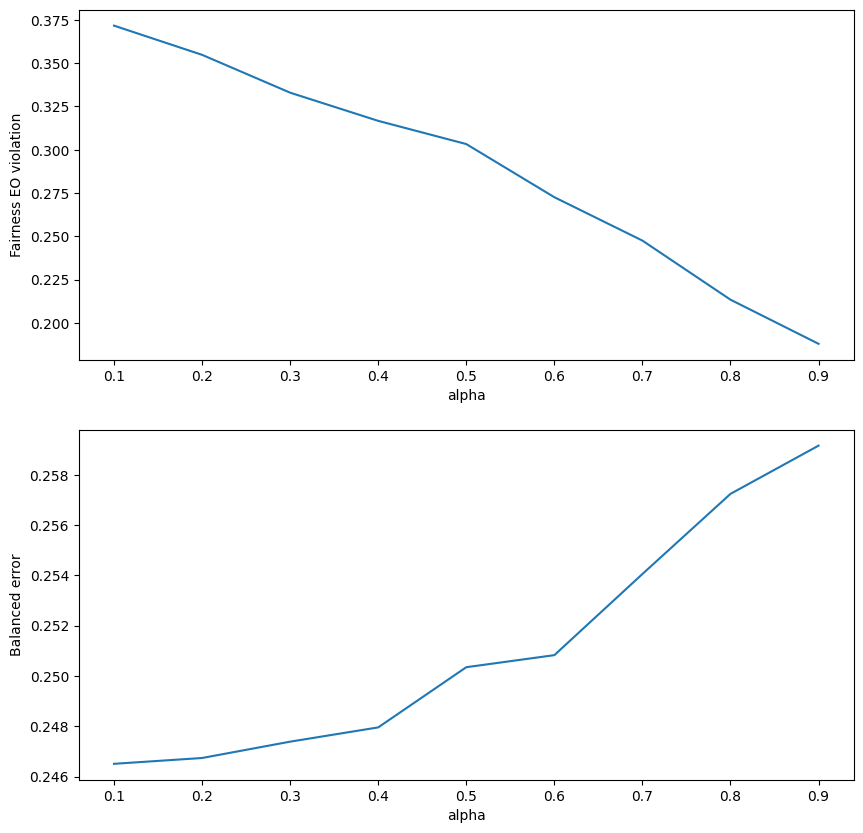

In [4]:
x_train, y_train, x_test, y_test = load_adult("../data/")
accuracy, fairness_score = main(x_train, y_train, x_test, y_test, lambdas=[0.1] * 9)

fig, axs = plt.subplots(2, figsize=(10, 10))
axs[0].plot(fairness_score)
axs[0].set_ylabel("Fairness EO violation")
axs[0].set_xlabel("alpha")
axs[0].set_xticklabels(np.arange(0, 10) / 10)

axs[1].plot(accuracy)
axs[1].set_ylabel("Balanced error")
axs[1].set_xlabel("alpha")
axs[1].set_xticklabels(np.arange(0, 10) / 10)

plt.show()